# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
#!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output
!python -m pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null --user 

지정된 경로를 찾을 수 없습니다.


In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\bengaliai-cv19\class_map.csv
../input\bengaliai-cv19\sample_submission.csv
../input\bengaliai-cv19\test.csv
../input\bengaliai-cv19\test_image_data_0.parquet
../input\bengaliai-cv19\test_image_data_1.parquet
../input\bengaliai-cv19\test_image_data_2.parquet
../input\bengaliai-cv19\test_image_data_3.parquet
../input\bengaliai-cv19\train.csv
../input\bengaliai-cv19\train_image_data_0.parquet
../input\bengaliai-cv19\train_image_data_1.parquet
../input\bengaliai-cv19\train_image_data_2.parquet
../input\bengaliai-cv19\train_image_data_3.parquet
../input\bengaliaicv19feather\test_image_data_0.feather
../input\bengaliaicv19feather\test_image_data_1.feather
../input\bengaliaicv19feather\test_image_data_2.feather
../input\bengaliaicv19feather\test_image_data_3.feather
../input\bengaliaicv19feather\train_image_data_0.feather
../input\bengaliaicv19feather\train_image_data_1.feather
../input\bengaliaicv19feather\train_image_data_2.feather
../input\bengaliaicv19feather\train_image_data_3.f

In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [5]:
debug=False
submission=False
batch_size=32*2
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [6]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [7]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
os.listdir(r"../input")

['bengaliai-cv19', 'bengaliaicv19feather']

In [10]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 14.9 s


In [11]:
os.listdir("../input/bengaliaicv19feather/")

['test_image_data_0.feather',
 'test_image_data_1.feather',
 'test_image_data_2.feather',
 'test_image_data_3.feather',
 'train_image_data_0.feather',
 'train_image_data_1.feather',
 'train_image_data_2.feather',
 'train_image_data_3.feather']

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


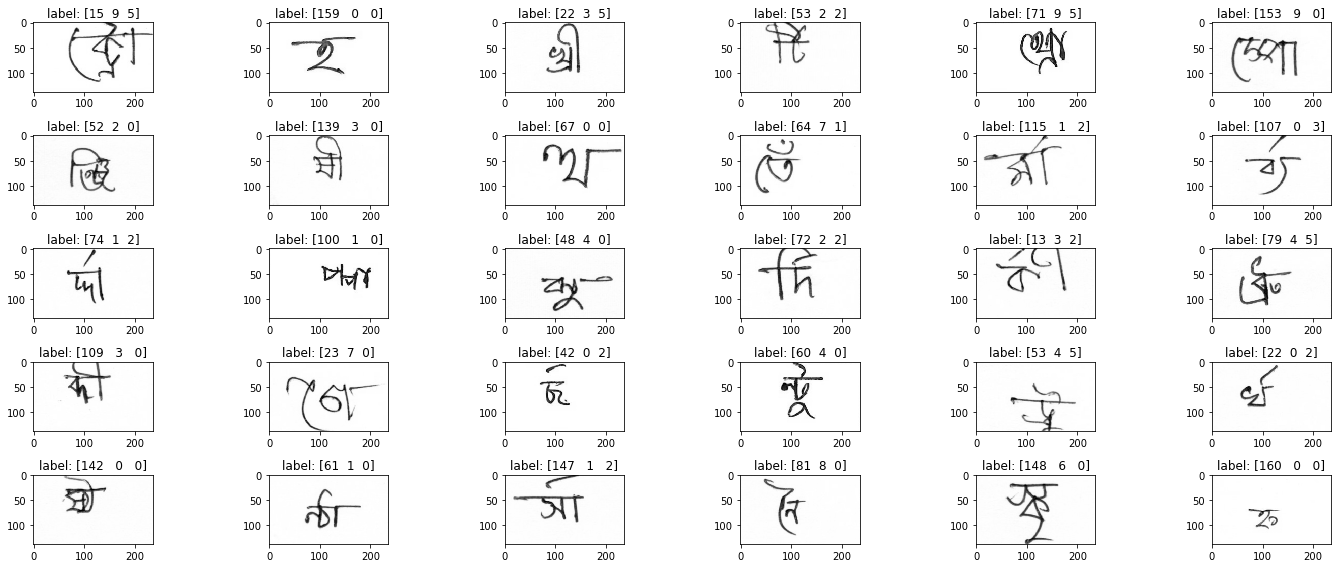

<Figure size 432x288 with 0 Axes>

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [16]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [17]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

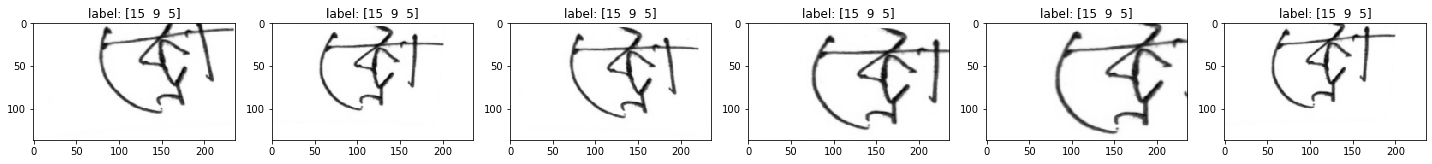

In [18]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

## crop image

Here I crop image

## resize image

We need to resize image after crop, to align image size for CNN batch training.

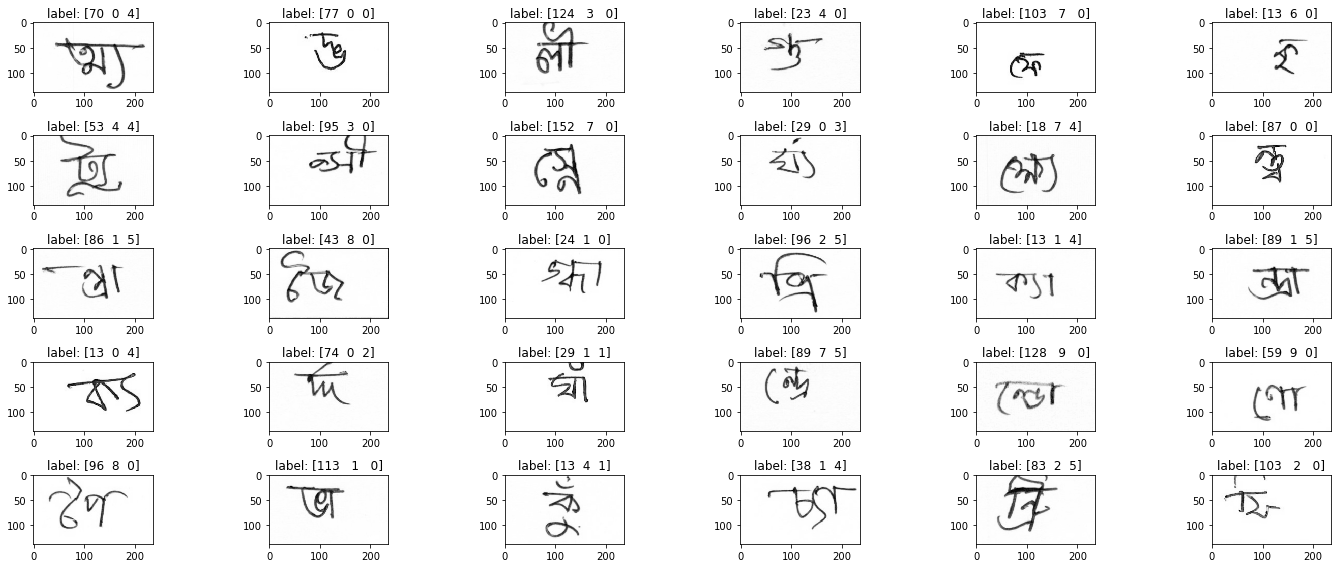

In [19]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

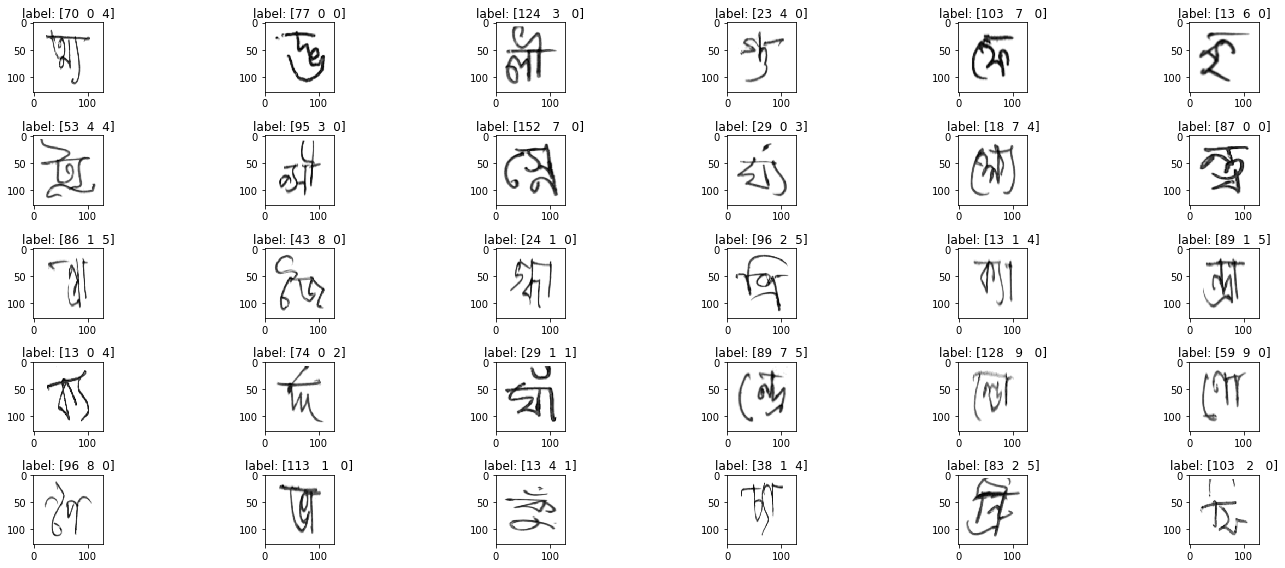

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [21]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
        
        
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         #if self.sigma > 0.:
#         #    x = add_gaussian_noise(x, sigma=self.sigma)

        
#         #plt.imshow(x)
#         #plt.show()
        
#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
        
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)
                

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.Cutout(max_h_size=8, max_w_size=8, p=1.0), x)
#             #x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)
        
# #         # 난수생성
# #         const = np.random.rand(1)[0]
        
#         # Erosion, dilation
# #         if const<0.5:
# #             x = erosion(x)
# #         else:
# #             x = dilation(x)
        
        
        
# #         if const<0.15:
# #             x = erosion(x)
# #         elif const<0.3:
# #             x = dilation(x)
# #         elif const<0.45:
# #             x = opening(x)
# #         elif const<0.6:
# #             x = closing(x)
        
# #         plt.imshow(x)
# #         plt.show()

        
#         #if self.normalize:
#         #    x = (x.astype(np.double) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.double)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        
#         # normalize by its max val
#         x = x * (255./x.max())
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [22]:
# train_transform = Transform(
#     size=(image_size, image_size), threshold=20.,
#     sigma=-1., blur_ratio=0.1, noise_ratio=0, cutout_ratio=0.2,
#     grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
#     piece_affine_ratio=0.2, ssr_ratio=0.2)
# train_dataset = BengaliAIDataset(train_images, train_labels,
#                                  transform=train_transform)

# for i in range(10):
#     train_dataset[0]

In [23]:
train_transform = Transform(
    size=(236, 137), threshold=40.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

### Let's final check the processed images, which will be trained by the model.

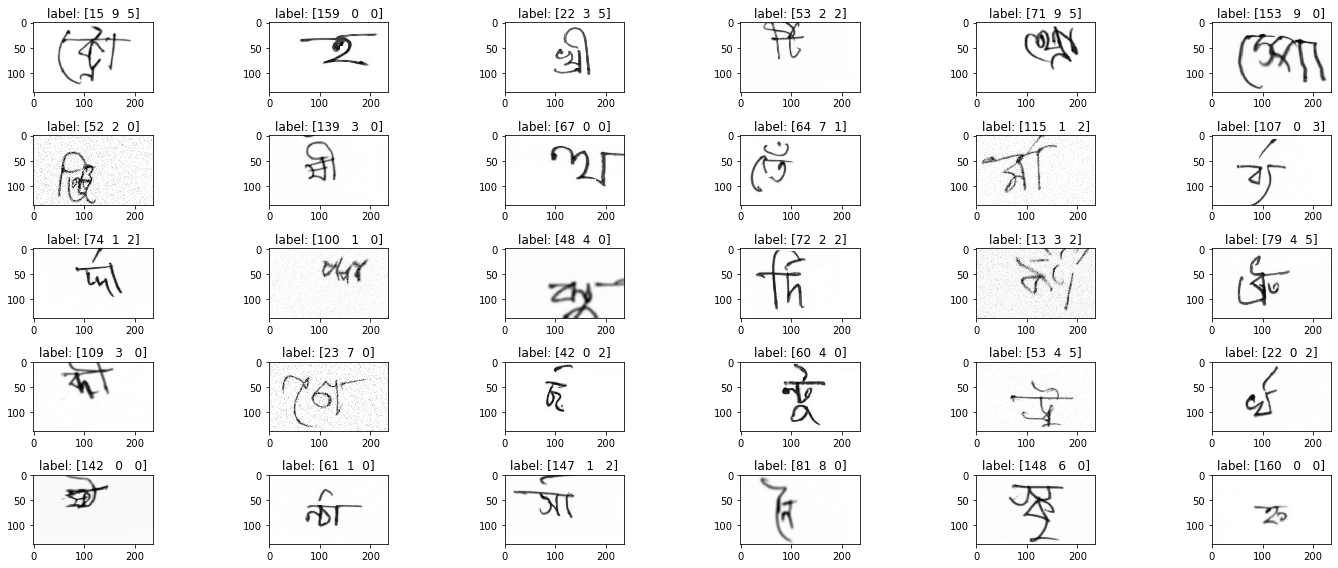

In [24]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [25]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [26]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [27]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [28]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [29]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [30]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [31]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(10)
        
        if const<4:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        elif const<8:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
            
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<8:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [32]:
# import numpy as np
# import pandas as pd
# import iterstrat
# #!pip install iterative-stratification


# #get data
# nfold = 5
# seed = 12

# train_df = copy.copy(train)
# train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

# X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
# .values[:,0], train_df.values[:,1:]

# train_df['fold'] = np.nan

# #split data
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
# for i, (_, test_index) in enumerate(mskf.split(X, y)):
#     train_df.iloc[test_index, -1] = i
    
# train_df['fold'] = train_df['fold'].astype('int')

In [33]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(236, 137)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\dohee\Anaconda3\envs\Bengali\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [47]:
# #load weights
predictor.load_state_dict(torch.load(r"D:\kaggle\Bengali\Bengali\save\model_000010.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

## Ignite utility

pytorch-ignite utility class for training

In [48]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [49]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [50]:
# from ignite.handlers import ModelCheckpoint

# checkpoint_every = 10

# dirname = r"./save"
# engine_checkpoint = ModelCheckpoint(
#     dirname=dirname,
#     'my_model',
#     save_interval=checkpoint_every,
#     create_dir = True)

In [51]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [ ]:
trainer.run(train_loader, max_epochs=90)

{'epoch': 1, 'iteration': 2511, 'train/loss': 3.0960587905797765, 'train/loss_grapheme': 1.1015100535146272, 'train/loss_vowel': 0.5415427833569301, 'train/loss_consonant': 0.35149590116200435, 'train/acc_grapheme': 0.6450679510155317, 'train/acc_vowel': 0.7353768418956591, 'train/acc_consonant': 0.8234269215452011, 'train/recall': 0.6990020884895548, 'valid/loss': 0.563888214291281, 'valid/loss_grapheme': 0.18554515854283504, 'valid/loss_vowel': 0.10475574215506292, 'valid/loss_consonant': 0.08804215470649254, 'valid/acc_grapheme': 0.9577726910828026, 'valid/acc_vowel': 0.9868232484076433, 'valid/acc_consonant': 0.9867635350318471, 'valid/recall': 0.9720973749951723, 'lr': 0.001, 'elapsed_time': 2388.7254109999994}
epoch      1 train/loss  3.096059 train/loss_grapheme  1.101510 train/loss_vowel  0.541543 train/loss_consonant  0.351496 train/acc_grapheme  0.645068 train/acc_vowel  0.735377 train/acc_consonant  0.823427 train/recall  0.699002 valid/loss  0.563888 valid/loss_grapheme  0.

{'epoch': 2, 'iteration': 5022, 'train/loss': 3.044596664091236, 'train/loss_grapheme': 1.0843253501133465, 'train/loss_vowel': 0.5309795290235414, 'train/loss_consonant': 0.3449664362255604, 'train/acc_grapheme': 0.635846027479092, 'train/acc_vowel': 0.7255699920350458, 'train/acc_consonant': 0.8187226204699323, 'train/recall': 0.6890419321546504, 'valid/loss': 0.614814213506735, 'valid/loss_grapheme': 0.20050890311883512, 'valid/loss_vowel': 0.11718323953734462, 'valid/loss_consonant': 0.09661316818848348, 'valid/acc_grapheme': 0.9570909633757962, 'valid/acc_vowel': 0.986609275477707, 'valid/acc_consonant': 0.9863256369426752, 'valid/recall': 0.9693405342772772, 'lr': 0.001, 'elapsed_time': 4778.1478305000055}
epoch      2 train/loss  3.044597 train/loss_grapheme  1.084325 train/loss_vowel  0.530980 train/loss_consonant  0.344966 train/acc_grapheme  0.635846 train/acc_vowel  0.725570 train/acc_consonant  0.818723 train/recall  0.689042 valid/loss  0.614814 valid/loss_grapheme  0.2005

{'epoch': 3, 'iteration': 7533, 'train/loss': 3.059690374502714, 'train/loss_grapheme': 1.0853287368591493, 'train/loss_vowel': 0.5401936274263689, 'train/loss_consonant': 0.3488392702343513, 'train/acc_grapheme': 0.6459142273994425, 'train/acc_vowel': 0.7325953305455993, 'train/acc_consonant': 0.8228731083233771, 'train/recall': 0.7007529051664573, 'valid/loss': 0.6595387380973549, 'valid/loss_grapheme': 0.2069336756185931, 'valid/loss_vowel': 0.1368172065277768, 'valid/loss_consonant': 0.10885418050441963, 'valid/acc_grapheme': 0.955812101910828, 'valid/acc_vowel': 0.9866988455414013, 'valid/acc_consonant': 0.9854448646496815, 'valid/recall': 0.9689657139216385, 'lr': 0.001, 'elapsed_time': 7234.113547699999}
epoch      3 train/loss  3.059690 train/loss_grapheme  1.085329 train/loss_vowel  0.540194 train/loss_consonant  0.348839 train/acc_grapheme  0.645914 train/acc_vowel  0.732595 train/acc_consonant  0.822873 train/recall  0.700753 valid/loss  0.659539 valid/loss_grapheme  0.20693

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

{'epoch': 9, 'iteration': 22599, 'train/loss': 2.8971780720862292, 'train/loss_grapheme': 1.0229205185816743, 'train/loss_vowel': 0.5167273245073116, 'train/loss_consonant': 0.3346097122088567, 'train/acc_grapheme': 0.65257243130227, 'train/acc_vowel': 0.7350781561131023, 'train/acc_consonant': 0.8264946734368778, 'train/recall': 0.7052842862503852, 'valid/loss': 0.49102097370062664, 'valid/loss_grapheme': 0.16570655541245344, 'valid/loss_vowel': 0.08743771167388957, 'valid/loss_consonant': 0.07217015142427982, 'valid/acc_grapheme': 0.9615445859872612, 'valid/acc_vowel': 0.9888883359872612, 'valid/acc_consonant': 0.9878085191082803, 'valid/recall': 0.9712893687081343, 'lr': 0.001, 'elapsed_time': 21476.442358600005}
epoch      9 train/loss  2.897178 train/loss_grapheme  1.022921 train/loss_vowel  0.516727 train/loss_consonant  0.334610 train/acc_grapheme  0.652572 train/acc_vowel  0.735078 train/acc_consonant  0.826495 train/recall  0.705284 valid/loss  0.491021 valid/loss_grapheme  0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'epoch': 10, 'iteration': 25110, 'train/loss': 2.8499006994457323, 'train/loss_grapheme': 1.0050420616428863, 'train/loss_vowel': 0.5086827075486459, 'train/loss_consonant': 0.33113387141307005, 'train/acc_grapheme': 0.6436429709279171, 'train/acc_vowel': 0.7284759557945042, 'train/acc_consonant': 0.8189092990840303, 'train/recall': 0.6955394076178338, 'valid/loss': 0.6105057606651525, 'valid/loss_grapheme': 0.20196202902752122, 'valid/loss_vowel': 0.11101536916651923, 'valid/loss_consonant': 0.09556633373425835, 'valid/acc_grapheme': 0.9608578821656052, 'valid/acc_vowel': 0.989609872611465, 'valid/acc_consonant': 0.9881070859872612, 'valid/recall': 0.9724106227662719, 'lr': 0.001, 'elapsed_time': 23839.145766100002}
epoch     10 train/loss  2.849901 train/loss_grapheme  1.005042 train/loss_vowel  0.508683 train/loss_consonant  0.331134 train/acc_grapheme  0.643643 train/acc_vowel  0.728476 train/acc_consonant  0.818909 train/recall  0.695539 valid/loss  0.610506 valid/loss_grapheme  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'epoch': 11, 'iteration': 27621, 'train/loss': 2.87287435468178, 'train/loss_grapheme': 1.014049354146933, 'train/loss_vowel': 0.5123014126491501, 'train/loss_consonant': 0.3324742317629948, 'train/acc_grapheme': 0.6650985663082437, 'train/acc_vowel': 0.7442814117881322, 'train/acc_consonant': 0.8329288630027878, 'train/recall': 0.7157991767232768, 'valid/loss': 0.451910514443828, 'valid/loss_grapheme': 0.15962269675034058, 'valid/loss_vowel': 0.06835395989903978, 'valid/loss_consonant': 0.06431116133180868, 'valid/acc_grapheme': 0.9607732882165605, 'valid/acc_vowel': 0.9889978105095543, 'valid/acc_consonant': 0.9879179936305733, 'valid/recall': 0.9717646122178096, 'lr': 0.001, 'elapsed_time': 26197.436403500004}
epoch     11 train/loss  2.872874 train/loss_grapheme  1.014049 train/loss_vowel  0.512301 train/loss_consonant  0.332474 train/acc_grapheme  0.665099 train/acc_vowel  0.744281 train/acc_consonant  0.832929 train/recall  0.715799 valid/loss  0.451911 valid/loss_grapheme  0.15

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

{'epoch': 19, 'iteration': 47709, 'train/loss': 2.733060743673087, 'train/loss_grapheme': 0.9619302736919437, 'train/loss_vowel': 0.4892942839667827, 'train/loss_consonant': 0.31990591549822317, 'train/acc_grapheme': 0.6530142373556352, 'train/acc_vowel': 0.7367582636399841, 'train/acc_consonant': 0.8245158801274393, 'train/recall': 0.7035138781286772, 'valid/loss': 0.5047605968299945, 'valid/loss_grapheme': 0.16105494025359107, 'valid/loss_vowel': 0.10030263716912573, 'valid/loss_consonant': 0.08234807960451788, 'valid/acc_grapheme': 0.9645700636942676, 'valid/acc_vowel': 0.9900676751592358, 'valid/acc_consonant': 0.9883409633757962, 'valid/recall': 0.9751192054025948, 'lr': 0.001, 'elapsed_time': 45170.8598976}
epoch     19 train/loss  2.733061 train/loss_grapheme  0.961930 train/loss_vowel  0.489294 train/loss_consonant  0.319906 train/acc_grapheme  0.653014 train/acc_vowel  0.736758 train/acc_consonant  0.824516 train/recall  0.703514 valid/loss  0.504761 valid/loss_grapheme  0.161

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'epoch': 20, 'iteration': 50220, 'train/loss': 2.8054840387913726, 'train/loss_grapheme': 0.9856213053198081, 'train/loss_vowel': 0.5040500736072117, 'train/loss_consonant': 0.330191357104291, 'train/acc_grapheme': 0.6491499900438072, 'train/acc_vowel': 0.7327820091596974, 'train/acc_consonant': 0.821417015133413, 'train/recall': 0.7012768720891295, 'valid/loss': 0.5167045241613297, 'valid/loss_grapheme': 0.16443175650468678, 'valid/loss_vowel': 0.10301443244550068, 'valid/loss_consonant': 0.08482657693872217, 'valid/acc_grapheme': 0.963186703821656, 'valid/acc_vowel': 0.989361066878981, 'valid/acc_consonant': 0.9878582802547771, 'valid/recall': 0.972654319161994, 'lr': 0.001, 'elapsed_time': 47560.014574299996}
epoch     20 train/loss  2.805484 train/loss_grapheme  0.985621 train/loss_vowel  0.504050 train/loss_consonant  0.330191 train/acc_grapheme  0.649150 train/acc_vowel  0.732782 train/acc_consonant  0.821417 train/recall  0.701277 valid/loss  0.516705 valid/loss_grapheme  0.164

{'epoch': 21, 'iteration': 52731, 'train/loss': 2.7273113375959146, 'train/loss_grapheme': 0.9584470484220308, 'train/loss_vowel': 0.49004073317371505, 'train/loss_consonant': 0.3203765060648779, 'train/acc_grapheme': 0.6623917264038232, 'train/acc_vowel': 0.7426324173636002, 'train/acc_consonant': 0.8291890681003584, 'train/recall': 0.7095600018644503, 'valid/loss': 0.4692537760611173, 'valid/loss_grapheme': 0.15508669225060068, 'valid/loss_vowel': 0.08795848953282567, 'valid/loss_consonant': 0.07112190249571755, 'valid/acc_grapheme': 0.9648935111464968, 'valid/acc_vowel': 0.9897591560509554, 'valid/acc_consonant': 0.989361066878981, 'valid/recall': 0.9736327498669742, 'lr': 0.001, 'elapsed_time': 49967.244600900005}
epoch     21 train/loss  2.727311 train/loss_grapheme  0.958447 train/loss_vowel  0.490041 train/loss_consonant  0.320377 train/acc_grapheme  0.662392 train/acc_vowel  0.742632 train/acc_consonant  0.829189 train/recall  0.709560 valid/loss  0.469254 valid/loss_grapheme  

{'epoch': 22, 'iteration': 55242, 'train/loss': 2.8126301933532454, 'train/loss_grapheme': 0.9901977813606455, 'train/loss_vowel': 0.5044891607140205, 'train/loss_consonant': 0.3277454721277386, 'train/acc_grapheme': 0.6480236957387495, 'train/acc_vowel': 0.7330682497013142, 'train/acc_consonant': 0.8239433990442055, 'train/recall': 0.7011207079537617, 'valid/loss': 0.45960465894573055, 'valid/loss_grapheme': 0.15174876297023265, 'valid/loss_vowel': 0.08579144625669452, 'valid/loss_consonant': 0.07031568730024586, 'valid/acc_grapheme': 0.9638335987261147, 'valid/acc_vowel': 0.9901074840764331, 'valid/acc_consonant': 0.9893013535031847, 'valid/recall': 0.9759293142248, 'lr': 0.001, 'elapsed_time': 52364.1798185}
epoch     22 train/loss  2.812630 train/loss_grapheme  0.990198 train/loss_vowel  0.504489 train/loss_consonant  0.327745 train/acc_grapheme  0.648024 train/acc_vowel  0.733068 train/acc_consonant  0.823943 train/recall  0.701121 valid/loss  0.459605 valid/loss_grapheme  0.15174

{'epoch': 23, 'iteration': 57753, 'train/loss': 2.747461824410468, 'train/loss_grapheme': 0.9653214790262297, 'train/loss_vowel': 0.4938045915584137, 'train/loss_consonant': 0.3230142770969312, 'train/acc_grapheme': 0.6645634209478295, 'train/acc_vowel': 0.747977648347272, 'train/acc_consonant': 0.8326177319792911, 'train/recall': 0.7164495759844147, 'valid/loss': 0.44090414517054893, 'valid/loss_grapheme': 0.15016072966858365, 'valid/loss_vowel': 0.07372361318368441, 'valid/loss_consonant': 0.06685907356618981, 'valid/acc_grapheme': 0.9633011544585988, 'valid/acc_vowel': 0.990032842356688, 'valid/acc_consonant': 0.9883061305732485, 'valid/recall': 0.9737838389728406, 'lr': 0.001, 'elapsed_time': 54738.48955610001}
epoch     23 train/loss  2.747462 train/loss_grapheme  0.965321 train/loss_vowel  0.493805 train/loss_consonant  0.323014 train/acc_grapheme  0.664563 train/acc_vowel  0.747978 train/acc_consonant  0.832618 train/recall  0.716450 valid/loss  0.440904 valid/loss_grapheme  0.1

{'epoch': 24, 'iteration': 60264, 'train/loss': 2.634447022661276, 'train/loss_grapheme': 0.9254310749154442, 'train/loss_vowel': 0.47408243871658556, 'train/loss_consonant': 0.309502431000492, 'train/acc_grapheme': 0.6693299482277977, 'train/acc_vowel': 0.7485625746714456, 'train/acc_consonant': 0.8335324571883712, 'train/recall': 0.717857834180042, 'valid/loss': 0.4633384135545819, 'valid/loss_grapheme': 0.1524990751722436, 'valid/loss_vowel': 0.08543902581000025, 'valid/loss_consonant': 0.07290123739416242, 'valid/acc_grapheme': 0.9640326433121019, 'valid/acc_vowel': 0.9894605891719745, 'valid/acc_consonant': 0.9883658439490446, 'valid/recall': 0.9730339172911279, 'lr': 0.001, 'elapsed_time': 57087.301811100006}
epoch     24 train/loss  2.634447 train/loss_grapheme  0.925431 train/loss_vowel  0.474082 train/loss_consonant  0.309502 train/acc_grapheme  0.669330 train/acc_vowel  0.748563 train/acc_consonant  0.833532 train/recall  0.717858 valid/loss  0.463338 valid/loss_grapheme  0.1

{'epoch': 25, 'iteration': 62775, 'train/loss': 2.65134632403913, 'train/loss_grapheme': 0.9294884050593569, 'train/loss_vowel': 0.47954403463219214, 'train/loss_consonant': 0.31282547778590525, 'train/acc_grapheme': 0.6676249502190362, 'train/acc_vowel': 0.7443187475109518, 'train/acc_consonant': 0.8314167662285942, 'train/recall': 0.7137297641733615, 'valid/loss': 0.427004697347048, 'valid/loss_grapheme': 0.14585911659345885, 'valid/loss_vowel': 0.06815920564921418, 'valid/loss_consonant': 0.06712725861769193, 'valid/acc_grapheme': 0.9639480493630573, 'valid/acc_vowel': 0.9893710191082803, 'valid/acc_consonant': 0.9877687101910828, 'valid/recall': 0.9731670346620898, 'lr': 0.001, 'elapsed_time': 59446.8249878}
epoch     25 train/loss  2.651346 train/loss_grapheme  0.929488 train/loss_vowel  0.479544 train/loss_consonant  0.312825 train/acc_grapheme  0.667625 train/acc_vowel  0.744319 train/acc_consonant  0.831417 train/recall  0.713730 valid/loss  0.427005 valid/loss_grapheme  0.1458

{'epoch': 26, 'iteration': 65286, 'train/loss': 2.626068717089071, 'train/loss_grapheme': 0.9204261274225728, 'train/loss_vowel': 0.4744347331248749, 'train/loss_consonant': 0.3107817298037266, 'train/acc_grapheme': 0.6689130326563122, 'train/acc_vowel': 0.7463659896455596, 'train/acc_consonant': 0.8311180804460374, 'train/recall': 0.7162589931150931, 'valid/loss': 0.4165637705973379, 'valid/loss_grapheme': 0.14110440395440266, 'valid/loss_vowel': 0.06877933550554856, 'valid/loss_consonant': 0.06557562722450798, 'valid/acc_grapheme': 0.9662718949044586, 'valid/acc_vowel': 0.9897342754777071, 'valid/acc_consonant': 0.9889779060509554, 'valid/recall': 0.9750513367262109, 'lr': 0.001, 'elapsed_time': 61803.1150769}
epoch     26 train/loss  2.626069 train/loss_grapheme  0.920426 train/loss_vowel  0.474435 train/loss_consonant  0.310782 train/acc_grapheme  0.668913 train/acc_vowel  0.746366 train/acc_consonant  0.831118 train/recall  0.716259 valid/loss  0.416564 valid/loss_grapheme  0.1411

{'epoch': 27, 'iteration': 67797, 'train/loss': 2.7468839035369825, 'train/loss_grapheme': 0.9630456114497906, 'train/loss_vowel': 0.4963231156811961, 'train/loss_consonant': 0.32446956442396796, 'train/acc_grapheme': 0.6584154719235364, 'train/acc_vowel': 0.739247311827957, 'train/acc_consonant': 0.827384508164078, 'train/recall': 0.7068239742565962, 'valid/loss': 0.48190200687119156, 'valid/loss_grapheme': 0.16051813153324612, 'valid/loss_vowel': 0.08548331960062881, 'valid/loss_consonant': 0.07538242407949866, 'valid/acc_grapheme': 0.9631618232484077, 'valid/acc_vowel': 0.9901074840764331, 'valid/acc_consonant': 0.9886544585987261, 'valid/recall': 0.9743289227305154, 'lr': 0.001, 'elapsed_time': 64158.726915600004}
epoch     27 train/loss  2.746884 train/loss_grapheme  0.963046 train/loss_vowel  0.496323 train/loss_consonant  0.324470 train/acc_grapheme  0.658415 train/acc_vowel  0.739247 train/acc_consonant  0.827385 train/recall  0.706824 valid/loss  0.481902 valid/loss_grapheme  

{'epoch': 28, 'iteration': 70308, 'train/loss': 2.6559824524547464, 'train/loss_grapheme': 0.9315390469159965, 'train/loss_vowel': 0.4783999106816336, 'train/loss_consonant': 0.3145044500316812, 'train/acc_grapheme': 0.6642522899243329, 'train/acc_vowel': 0.7447481083233771, 'train/acc_consonant': 0.8293010752688172, 'train/recall': 0.7116446226096586, 'valid/loss': 0.4332174737552169, 'valid/loss_grapheme': 0.1486187055588338, 'valid/loss_vowel': 0.06913773923115746, 'valid/loss_consonant': 0.06684232321063614, 'valid/acc_grapheme': 0.9639331210191083, 'valid/acc_vowel': 0.9900079617834395, 'valid/acc_consonant': 0.9878682324840765, 'valid/recall': 0.9736028112194371, 'lr': 0.001, 'elapsed_time': 66515.22526539999}
epoch     28 train/loss  2.655982 train/loss_grapheme  0.931539 train/loss_vowel  0.478400 train/loss_consonant  0.314504 train/acc_grapheme  0.664252 train/acc_vowel  0.744748 train/acc_consonant  0.829301 train/recall  0.711645 valid/loss  0.433217 valid/loss_grapheme  0.

{'epoch': 29, 'iteration': 72819, 'train/loss': 2.6911909919557035, 'train/loss_grapheme': 0.9443257803914082, 'train/loss_vowel': 0.4864083539838456, 'train/loss_consonant': 0.3161310757076785, 'train/acc_grapheme': 0.6648185483870968, 'train/acc_vowel': 0.7435782556750299, 'train/acc_consonant': 0.8305269315013939, 'train/recall': 0.7132944302410157, 'valid/loss': 0.478373784619342, 'valid/loss_grapheme': 0.15916341120839878, 'valid/loss_vowel': 0.08219250726994055, 'valid/loss_consonant': 0.0778544566766092, 'valid/acc_grapheme': 0.964390923566879, 'valid/acc_vowel': 0.9900925557324841, 'valid/acc_consonant': 0.9883409633757962, 'valid/recall': 0.9761903974128492, 'lr': 0.001, 'elapsed_time': 68876.470859}
epoch     29 train/loss  2.691191 train/loss_grapheme  0.944326 train/loss_vowel  0.486408 train/loss_consonant  0.316131 train/acc_grapheme  0.664819 train/acc_vowel  0.743578 train/acc_consonant  0.830527 train/recall  0.713294 valid/loss  0.478374 valid/loss_grapheme  0.159163 

{'epoch': 30, 'iteration': 75330, 'train/loss': 2.7788120711860977, 'train/loss_grapheme': 0.9744230896703326, 'train/loss_vowel': 0.5022476185591649, 'train/loss_consonant': 0.32771827150670324, 'train/acc_grapheme': 0.6561317702110713, 'train/acc_vowel': 0.7385441557148547, 'train/acc_consonant': 0.8274218438868977, 'train/recall': 0.7064555711801281, 'valid/loss': 0.4672750744043262, 'valid/loss_grapheme': 0.1573259725597254, 'valid/loss_vowel': 0.081581421018501, 'valid/loss_consonant': 0.07104170880915159, 'valid/acc_grapheme': 0.9639729299363057, 'valid/acc_vowel': 0.9897939888535032, 'valid/acc_consonant': 0.9872810509554141, 'valid/recall': 0.973648850952146, 'lr': 0.001, 'elapsed_time': 71247.51983209999}
epoch     30 train/loss  2.778812 train/loss_grapheme  0.974423 train/loss_vowel  0.502248 train/loss_consonant  0.327718 train/acc_grapheme  0.656132 train/acc_vowel  0.738544 train/acc_consonant  0.827422 train/recall  0.706456 valid/loss  0.467275 valid/loss_grapheme  0.15

{'epoch': 31, 'iteration': 77841, 'train/loss': 2.6846944670315662, 'train/loss_grapheme': 0.9419192354621723, 'train/loss_vowel': 0.484314100807388, 'train/loss_consonant': 0.31654189172049163, 'train/acc_grapheme': 0.6642958482676224, 'train/acc_vowel': 0.7437027080844285, 'train/acc_consonant': 0.8291268418956591, 'train/recall': 0.71044043462433, 'valid/loss': 0.45237904089461467, 'valid/loss_grapheme': 0.15480940943216062, 'valid/loss_vowel': 0.07859964922046775, 'valid/loss_consonant': 0.06416057177469324, 'valid/acc_grapheme': 0.9652269108280255, 'valid/acc_vowel': 0.9899183917197453, 'valid/acc_consonant': 0.9888634554140128, 'valid/recall': 0.9757273009773322, 'lr': 0.001, 'elapsed_time': 73608.1986416}
epoch     31 train/loss  2.684694 train/loss_grapheme  0.941919 train/loss_vowel  0.484314 train/loss_consonant  0.316542 train/acc_grapheme  0.664296 train/acc_vowel  0.743703 train/acc_consonant  0.829127 train/recall  0.710440 valid/loss  0.452379 valid/loss_grapheme  0.1548

{'epoch': 32, 'iteration': 80352, 'train/loss': 2.564856969630134, 'train/loss_grapheme': 0.8972766299293258, 'train/loss_vowel': 0.46472907650137224, 'train/loss_consonant': 0.3055746366041043, 'train/acc_grapheme': 0.6673324870569495, 'train/acc_vowel': 0.7454325965750697, 'train/acc_consonant': 0.8313607626443648, 'train/recall': 0.7146886533461807, 'valid/loss': 0.49751378474816393, 'valid/loss_grapheme': 0.1657164959699675, 'valid/loss_vowel': 0.09493653645299992, 'valid/loss_consonant': 0.0711442556878801, 'valid/acc_grapheme': 0.9621914808917198, 'valid/acc_vowel': 0.989858678343949, 'valid/acc_consonant': 0.9887042197452229, 'valid/recall': 0.9723596077975889, 'lr': 0.001, 'elapsed_time': 75976.94836750001}
epoch     32 train/loss  2.564857 train/loss_grapheme  0.897277 train/loss_vowel  0.464729 train/loss_consonant  0.305575 train/acc_grapheme  0.667332 train/acc_vowel  0.745433 train/acc_consonant  0.831361 train/recall  0.714689 valid/loss  0.497514 valid/loss_grapheme  0.1

{'epoch': 33, 'iteration': 82863, 'train/loss': 2.5976069147491994, 'train/loss_grapheme': 0.9101569216234044, 'train/loss_vowel': 0.46931340538480104, 'train/loss_consonant': 0.30797966407913874, 'train/acc_grapheme': 0.6590252887295898, 'train/acc_vowel': 0.7385130426125049, 'train/acc_consonant': 0.8263079948227797, 'train/recall': 0.7059414695733478, 'valid/loss': 0.4659880955887448, 'valid/loss_grapheme': 0.15324150807680978, 'valid/loss_vowel': 0.0875695908240452, 'valid/loss_consonant': 0.07193548882759776, 'valid/acc_grapheme': 0.9655503582802548, 'valid/acc_vowel': 0.9898935111464969, 'valid/acc_consonant': 0.9884653662420383, 'valid/recall': 0.9746391905400851, 'lr': 0.001, 'elapsed_time': 78347.80300459999}
epoch     33 train/loss  2.597607 train/loss_grapheme  0.910157 train/loss_vowel  0.469313 train/loss_consonant  0.307980 train/acc_grapheme  0.659025 train/acc_vowel  0.738513 train/acc_consonant  0.826308 train/recall  0.705941 valid/loss  0.465988 valid/loss_grapheme  

{'epoch': 34, 'iteration': 85374, 'train/loss': 2.5973285530482046, 'train/loss_grapheme': 0.9105179999928665, 'train/loss_vowel': 0.46809465145749346, 'train/loss_consonant': 0.3081979031634878, 'train/acc_grapheme': 0.6626095181202708, 'train/acc_vowel': 0.7424457387495021, 'train/acc_consonant': 0.827844982078853, 'train/recall': 0.7095714979995118, 'valid/loss': 0.5470705660665112, 'valid/loss_grapheme': 0.17151725134414852, 'valid/loss_vowel': 0.12148296586267508, 'valid/loss_consonant': 0.0825530974502871, 'valid/acc_grapheme': 0.9645153264331211, 'valid/acc_vowel': 0.9898835589171975, 'valid/acc_consonant': 0.9891371417197452, 'valid/recall': 0.976692836216877, 'lr': 0.001, 'elapsed_time': 80710.340869}
epoch     34 train/loss  2.597329 train/loss_grapheme  0.910518 train/loss_vowel  0.468095 train/loss_consonant  0.308198 train/acc_grapheme  0.662610 train/acc_vowel  0.742446 train/acc_consonant  0.827845 train/recall  0.709571 valid/loss  0.547071 valid/loss_grapheme  0.171517

{'epoch': 35, 'iteration': 87885, 'train/loss': 2.5683523902898764, 'train/loss_grapheme': 0.900211455571947, 'train/loss_vowel': 0.46469449516284167, 'train/loss_consonant': 0.30323498111629166, 'train/acc_grapheme': 0.664799880525687, 'train/acc_vowel': 0.7436529271206691, 'train/acc_consonant': 0.8296557646356033, 'train/recall': 0.7097210000178591, 'valid/loss': 0.42738296976609597, 'valid/loss_grapheme': 0.14658212986223068, 'valid/loss_vowel': 0.0734119546024283, 'valid/loss_consonant': 0.06080675538878437, 'valid/acc_grapheme': 0.96671974522293, 'valid/acc_vowel': 0.9905951433121019, 'valid/acc_consonant': 0.9895103503184713, 'valid/recall': 0.9766218373315695, 'lr': 0.001, 'elapsed_time': 83076.8027346}
epoch     35 train/loss  2.568352 train/loss_grapheme  0.900211 train/loss_vowel  0.464694 train/loss_consonant  0.303235 train/acc_grapheme  0.664800 train/acc_vowel  0.743653 train/acc_consonant  0.829656 train/recall  0.709721 valid/loss  0.427383 valid/loss_grapheme  0.14658

{'epoch': 36, 'iteration': 90396, 'train/loss': 2.5682428803907618, 'train/loss_grapheme': 0.8987248643731297, 'train/loss_vowel': 0.4647990201975615, 'train/loss_consonant': 0.30599412684299554, 'train/acc_grapheme': 0.6603507068896853, 'train/acc_vowel': 0.7386437176423736, 'train/acc_consonant': 0.824540770609319, 'train/recall': 0.706887768228275, 'valid/loss': 0.4655790400163383, 'valid/loss_grapheme': 0.15054583736950425, 'valid/loss_vowel': 0.0878895780807183, 'valid/loss_consonant': 0.07659778691187596, 'valid/acc_grapheme': 0.9656001194267516, 'valid/acc_vowel': 0.9897591560509554, 'valid/acc_consonant': 0.9890376194267516, 'valid/recall': 0.9768710126489589, 'lr': 0.001, 'elapsed_time': 85434.7637632}
epoch     36 train/loss  2.568243 train/loss_grapheme  0.898725 train/loss_vowel  0.464799 train/loss_consonant  0.305994 train/acc_grapheme  0.660351 train/acc_vowel  0.738644 train/acc_consonant  0.824541 train/recall  0.706888 valid/loss  0.465579 valid/loss_grapheme  0.15054

{'epoch': 37, 'iteration': 92907, 'train/loss': 2.7316066103552332, 'train/loss_grapheme': 0.9569949712507851, 'train/loss_vowel': 0.4940615529613588, 'train/loss_consonant': 0.3235551225379768, 'train/acc_grapheme': 0.6550179211469535, 'train/acc_vowel': 0.7359182098765432, 'train/acc_consonant': 0.8236571585025886, 'train/recall': 0.7028674510017155, 'valid/loss': 0.43558167807378206, 'valid/loss_grapheme': 0.14987760896136046, 'valid/loss_vowel': 0.07103590842241504, 'valid/loss_consonant': 0.06479055185914989, 'valid/acc_grapheme': 0.9649283439490446, 'valid/acc_vowel': 0.9896347531847134, 'valid/acc_consonant': 0.9894755175159236, 'valid/recall': 0.9754221472748446, 'lr': 0.001, 'elapsed_time': 87842.55491909999}
epoch     37 train/loss  2.731607 train/loss_grapheme  0.956995 train/loss_vowel  0.494062 train/loss_consonant  0.323555 train/acc_grapheme  0.655018 train/acc_vowel  0.735918 train/acc_consonant  0.823657 train/recall  0.702867 valid/loss  0.435582 valid/loss_grapheme  

{'epoch': 38, 'iteration': 95418, 'train/loss': 2.7134375506926705, 'train/loss_grapheme': 0.9506115453908971, 'train/loss_vowel': 0.492041415468523, 'train/loss_consonant': 0.32017304493193727, 'train/acc_grapheme': 0.6567415870171247, 'train/acc_vowel': 0.735476403823178, 'train/acc_consonant': 0.8261648745519713, 'train/recall': 0.7037550365538627, 'valid/loss': 0.48677237792189715, 'valid/loss_grapheme': 0.16034751096562405, 'valid/loss_vowel': 0.09144224151731677, 'valid/loss_consonant': 0.0746351154343148, 'valid/acc_grapheme': 0.9650925557324841, 'valid/acc_vowel': 0.9906896894904459, 'valid/acc_consonant': 0.9885051751592356, 'valid/recall': 0.9758978122620814, 'lr': 0.001, 'elapsed_time': 90291.8044848}
epoch     38 train/loss  2.713438 train/loss_grapheme  0.950612 train/loss_vowel  0.492041 train/loss_consonant  0.320173 train/acc_grapheme  0.656742 train/acc_vowel  0.735476 train/acc_consonant  0.826165 train/recall  0.703755 valid/loss  0.486772 valid/loss_grapheme  0.1603

{'epoch': 39, 'iteration': 97929, 'train/loss': 2.5179515889204507, 'train/loss_grapheme': 0.8789374997530746, 'train/loss_vowel': 0.45928702059701493, 'train/loss_consonant': 0.3007895701539998, 'train/acc_grapheme': 0.6747436280366388, 'train/acc_vowel': 0.749732427319793, 'train/acc_consonant': 0.8341236061330147, 'train/recall': 0.720250771806444, 'valid/loss': 0.35071169197037344, 'valid/loss_grapheme': 0.12583216563590868, 'valid/loss_vowel': 0.04975657730665841, 'valid/loss_consonant': 0.04929078327918983, 'valid/acc_grapheme': 0.9687002388535032, 'valid/acc_vowel': 0.9916351512738855, 'valid/acc_consonant': 0.9897591560509554, 'valid/recall': 0.9780918591507932, 'lr': 0.0007, 'elapsed_time': 92737.3494677}
epoch     39 train/loss  2.517952 train/loss_grapheme  0.878937 train/loss_vowel  0.459287 train/loss_consonant  0.300790 train/acc_grapheme  0.674744 train/acc_vowel  0.749732 train/acc_consonant  0.834124 train/recall  0.720251 valid/loss  0.350712 valid/loss_grapheme  0.12

{'epoch': 40, 'iteration': 100440, 'train/loss': 2.5958821650702775, 'train/loss_grapheme': 0.9062478762796524, 'train/loss_vowel': 0.47438851317182357, 'train/loss_consonant': 0.30899789638755, 'train/acc_grapheme': 0.664345629231382, 'train/acc_vowel': 0.7423026184786937, 'train/acc_consonant': 0.829506421744325, 'train/recall': 0.7097326144968878, 'valid/loss': 0.39287365399965435, 'valid/loss_grapheme': 0.13512335668739145, 'valid/loss_vowel': 0.06544701009395586, 'valid/loss_consonant': 0.057179930563541544, 'valid/acc_grapheme': 0.9683519108280255, 'valid/acc_vowel': 0.990953423566879, 'valid/acc_consonant': 0.990047770700637, 'valid/recall': 0.9764988093364002, 'lr': 0.0007, 'elapsed_time': 95184.94204970001}
epoch     40 train/loss  2.595882 train/loss_grapheme  0.906248 train/loss_vowel  0.474389 train/loss_consonant  0.308998 train/acc_grapheme  0.664346 train/acc_vowel  0.742303 train/acc_consonant  0.829506 train/recall  0.709733 valid/loss  0.392874 valid/loss_grapheme  0.

{'epoch': 41, 'iteration': 102951, 'train/loss': 2.539031483252262, 'train/loss_grapheme': 0.8857141080780132, 'train/loss_vowel': 0.46363731508159195, 'train/loss_consonant': 0.3039659538763612, 'train/acc_grapheme': 0.6715763142174432, 'train/acc_vowel': 0.7457997311827957, 'train/acc_consonant': 0.8316843389088012, 'train/recall': 0.7159383205831021, 'valid/loss': 0.37868949827874543, 'valid/loss_grapheme': 0.12888912428882282, 'valid/loss_vowel': 0.06423650563332685, 'valid/loss_consonant': 0.056674743335172056, 'valid/acc_grapheme': 0.9695810111464969, 'valid/acc_vowel': 0.9919486464968154, 'valid/acc_consonant': 0.9905205015923567, 'valid/recall': 0.976582717093988, 'lr': 0.0007, 'elapsed_time': 97595.58687490001}
epoch     41 train/loss  2.539031 train/loss_grapheme  0.885714 train/loss_vowel  0.463637 train/loss_consonant  0.303966 train/acc_grapheme  0.671576 train/acc_vowel  0.745800 train/acc_consonant  0.831684 train/recall  0.715938 valid/loss  0.378689 valid/loss_grapheme

{'epoch': 42, 'iteration': 105462, 'train/loss': 2.4920592559201102, 'train/loss_grapheme': 0.8676552958066948, 'train/loss_vowel': 0.458164506267507, 'train/loss_consonant': 0.29858415561391777, 'train/acc_grapheme': 0.6704126841895659, 'train/acc_vowel': 0.7444307546794106, 'train/acc_consonant': 0.8309811827956989, 'train/recall': 0.714596246966687, 'valid/loss': 0.407861774656803, 'valid/loss_grapheme': 0.13949035549429573, 'valid/loss_vowel': 0.07033734161193204, 'valid/loss_consonant': 0.05854372302022804, 'valid/acc_grapheme': 0.9681528662420382, 'valid/acc_vowel': 0.9911176353503185, 'valid/acc_consonant': 0.9899233678343949, 'valid/recall': 0.9774126092768787, 'lr': 0.0007, 'elapsed_time': 100013.6070318}
epoch     42 train/loss  2.492059 train/loss_grapheme  0.867655 train/loss_vowel  0.458165 train/loss_consonant  0.298584 train/acc_grapheme  0.670413 train/acc_vowel  0.744431 train/acc_consonant  0.830981 train/recall  0.714596 valid/loss  0.407862 valid/loss_grapheme  0.13

{'epoch': 43, 'iteration': 107973, 'train/loss': 2.412938894459934, 'train/loss_grapheme': 0.8380551667277947, 'train/loss_vowel': 0.44575671896124086, 'train/loss_consonant': 0.29107184261039093, 'train/acc_grapheme': 0.6819245320589407, 'train/acc_vowel': 0.7521530266825965, 'train/acc_consonant': 0.8361646256471525, 'train/recall': 0.7244174519727817, 'valid/loss': 0.40222981029967214, 'valid/loss_grapheme': 0.13880819622071305, 'valid/loss_vowel': 0.06712148417451769, 'valid/loss_consonant': 0.057491934084137726, 'valid/acc_grapheme': 0.9679040605095541, 'valid/acc_vowel': 0.9910877786624205, 'valid/acc_consonant': 0.9907792595541401, 'valid/recall': 0.976951385251511, 'lr': 0.0007, 'elapsed_time': 102446.54128900002}
epoch     43 train/loss  2.412939 train/loss_grapheme  0.838055 train/loss_vowel  0.445757 train/loss_consonant  0.291072 train/acc_grapheme  0.681925 train/acc_vowel  0.752153 train/acc_consonant  0.836165 train/recall  0.724417 valid/loss  0.402230 valid/loss_graphe

{'epoch': 44, 'iteration': 110484, 'train/loss': 2.517972542338699, 'train/loss_grapheme': 0.8775345529950725, 'train/loss_vowel': 0.46098447051707825, 'train/loss_consonant': 0.30191896622203074, 'train/acc_grapheme': 0.6662808641975309, 'train/acc_vowel': 0.7428937674233373, 'train/acc_consonant': 0.8313669852648348, 'train/recall': 0.7111103869738435, 'valid/loss': 0.38090508362385117, 'valid/loss_grapheme': 0.13264871013771956, 'valid/loss_vowel': 0.06072087059758461, 'valid/loss_consonant': 0.054886793314366585, 'valid/acc_grapheme': 0.9683021496815286, 'valid/acc_vowel': 0.990953423566879, 'valid/acc_consonant': 0.990047770700637, 'valid/recall': 0.9766011613807126, 'lr': 0.0007, 'elapsed_time': 104847.9877459}
epoch     44 train/loss  2.517973 train/loss_grapheme  0.877535 train/loss_vowel  0.460984 train/loss_consonant  0.301919 train/acc_grapheme  0.666281 train/acc_vowel  0.742894 train/acc_consonant  0.831367 train/recall  0.711110 valid/loss  0.380905 valid/loss_grapheme  0

{'epoch': 45, 'iteration': 112995, 'train/loss': 2.4141542298184455, 'train/loss_grapheme': 0.8388028655754575, 'train/loss_vowel': 0.44389719246545073, 'train/loss_consonant': 0.2926513060188564, 'train/acc_grapheme': 0.677114446435683, 'train/acc_vowel': 0.7502489048187972, 'train/acc_consonant': 0.8329288630027878, 'train/recall': 0.7205762982333939, 'valid/loss': 0.3594461965024661, 'valid/loss_grapheme': 0.12510459134533147, 'valid/loss_vowel': 0.05691782912761448, 'valid/loss_consonant': 0.052319185191373914, 'valid/acc_grapheme': 0.9691232085987261, 'valid/acc_vowel': 0.991500796178344, 'valid/acc_consonant': 0.9906200238853503, 'valid/recall': 0.9767440214353448, 'lr': 0.0007, 'elapsed_time': 107236.11177320001}
epoch     45 train/loss  2.414154 train/loss_grapheme  0.838803 train/loss_vowel  0.443897 train/loss_consonant  0.292651 train/acc_grapheme  0.677114 train/acc_vowel  0.750249 train/acc_consonant  0.832929 train/recall  0.720576 valid/loss  0.359446 valid/loss_grapheme

{'epoch': 46, 'iteration': 115506, 'train/loss': 2.41654766248617, 'train/loss_grapheme': 0.839389456836236, 'train/loss_vowel': 0.4462010974662726, 'train/loss_consonant': 0.2915676503738204, 'train/acc_grapheme': 0.6728768418956591, 'train/acc_vowel': 0.7457001692552768, 'train/acc_consonant': 0.8311118578255675, 'train/recall': 0.716339926287286, 'valid/loss': 0.39935632319349773, 'valid/loss_grapheme': 0.13519299821038344, 'valid/loss_vowel': 0.07048775628802313, 'valid/loss_consonant': 0.058482570591483526, 'valid/acc_grapheme': 0.9688843550955414, 'valid/acc_vowel': 0.9914012738853504, 'valid/acc_consonant': 0.9906946656050956, 'valid/recall': 0.9785243970630788, 'lr': 0.0007, 'elapsed_time': 109605.6613526}
epoch     46 train/loss  2.416548 train/loss_grapheme  0.839389 train/loss_vowel  0.446201 train/loss_consonant  0.291568 train/acc_grapheme  0.672877 train/acc_vowel  0.745700 train/acc_consonant  0.831112 train/recall  0.716340 valid/loss  0.399356 valid/loss_grapheme  0.13

{'epoch': 47, 'iteration': 118017, 'train/loss': 2.524529031047257, 'train/loss_grapheme': 0.878754847601786, 'train/loss_vowel': 0.4633815488273635, 'train/loss_consonant': 0.3036377880088421, 'train/acc_grapheme': 0.6623855037833533, 'train/acc_vowel': 0.7377165471923537, 'train/acc_consonant': 0.828498357228196, 'train/recall': 0.7081642847211936, 'valid/loss': 0.36867662350747993, 'valid/loss_grapheme': 0.1291841275390878, 'valid/loss_vowel': 0.055921856127086146, 'valid/loss_consonant': 0.05438651269669555, 'valid/acc_grapheme': 0.9681031050955414, 'valid/acc_vowel': 0.9914510350318472, 'valid/acc_consonant': 0.9893511146496815, 'valid/recall': 0.9766272870216053, 'lr': 0.0007, 'elapsed_time': 111976.10725580002}
epoch     47 train/loss  2.524529 train/loss_grapheme  0.878755 train/loss_vowel  0.463382 train/loss_consonant  0.303638 train/acc_grapheme  0.662386 train/acc_vowel  0.737717 train/acc_consonant  0.828498 train/recall  0.708164 valid/loss  0.368677 valid/loss_grapheme  

{'epoch': 48, 'iteration': 120528, 'train/loss': 2.4366937150169137, 'train/loss_grapheme': 0.8477870874093532, 'train/loss_vowel': 0.44752520588436173, 'train/loss_consonant': 0.29359433365809945, 'train/acc_grapheme': 0.6765419653524493, 'train/acc_vowel': 0.7482887793707687, 'train/acc_consonant': 0.8350756670649144, 'train/recall': 0.7178646335615533, 'valid/loss': 0.4281418922410649, 'valid/loss_grapheme': 0.13771813919257586, 'valid/loss_vowel': 0.0827634663849025, 'valid/loss_consonant': 0.06994214854470104, 'valid/acc_grapheme': 0.9694566082802548, 'valid/acc_vowel': 0.9911375398089173, 'valid/acc_consonant': 0.9905553343949045, 'valid/recall': 0.9790915710352407, 'lr': 0.0007, 'elapsed_time': 114338.07470530001}
epoch     48 train/loss  2.436694 train/loss_grapheme  0.847787 train/loss_vowel  0.447525 train/loss_consonant  0.293594 train/acc_grapheme  0.676542 train/acc_vowel  0.748289 train/acc_consonant  0.835076 train/recall  0.717865 valid/loss  0.428142 valid/loss_graphem

{'epoch': 49, 'iteration': 123039, 'train/loss': 2.4927396122143652, 'train/loss_grapheme': 0.8682761219955465, 'train/loss_vowel': 0.45735295265056236, 'train/loss_consonant': 0.298834411613569, 'train/acc_grapheme': 0.6763428414974114, 'train/acc_vowel': 0.752202807646356, 'train/acc_consonant': 0.8369797889287136, 'train/recall': 0.7207937378940094, 'valid/loss': 0.37955726979739346, 'valid/loss_grapheme': 0.1304711551660565, 'valid/loss_vowel': 0.06538125851850031, 'valid/loss_consonant': 0.05323370116033182, 'valid/acc_grapheme': 0.9697054140127389, 'valid/acc_vowel': 0.9914510350318472, 'valid/acc_consonant': 0.9905951433121019, 'valid/recall': 0.978301510171582, 'lr': 0.0007, 'elapsed_time': 116702.74943170001}
epoch     49 train/loss  2.492740 train/loss_grapheme  0.868276 train/loss_vowel  0.457353 train/loss_consonant  0.298834 train/acc_grapheme  0.676343 train/acc_vowel  0.752203 train/acc_consonant  0.836980 train/recall  0.720794 valid/loss  0.379557 valid/loss_grapheme  

{'epoch': 50, 'iteration': 125550, 'train/loss': 2.4945122823067236, 'train/loss_grapheme': 0.8660076601447093, 'train/loss_vowel': 0.46256645584276096, 'train/loss_consonant': 0.29993050966348034, 'train/acc_grapheme': 0.6565673536439666, 'train/acc_vowel': 0.7308343289526085, 'train/acc_consonant': 0.823072232178415, 'train/recall': 0.701047302926487, 'valid/loss': 0.4456701865479065, 'valid/loss_grapheme': 0.14858639540423632, 'valid/loss_vowel': 0.08525918520227739, 'valid/loss_consonant': 0.06323820989353547, 'valid/acc_grapheme': 0.9697054140127389, 'valid/acc_vowel': 0.9913614649681529, 'valid/acc_consonant': 0.9908539012738854, 'valid/recall': 0.9792878101597152, 'lr': 0.00049, 'elapsed_time': 119081.3505161}
epoch     50 train/loss  2.494512 train/loss_grapheme  0.866008 train/loss_vowel  0.462566 train/loss_consonant  0.299931 train/acc_grapheme  0.656567 train/acc_vowel  0.730834 train/acc_consonant  0.823072 train/recall  0.701047 valid/loss  0.445670 valid/loss_grapheme  0

{'epoch': 51, 'iteration': 128061, 'train/loss': 2.340334879936912, 'train/loss_grapheme': 0.8105993119816914, 'train/loss_vowel': 0.4346068902783117, 'train/loss_consonant': 0.28452936992177547, 'train/acc_grapheme': 0.6823850059737157, 'train/acc_vowel': 0.7536028972520908, 'train/acc_consonant': 0.8360650637196336, 'train/recall': 0.7241071564168531, 'valid/loss': 0.41122454827188687, 'valid/loss_grapheme': 0.13820834650070804, 'valid/loss_vowel': 0.07429595510504998, 'valid/loss_consonant': 0.06051190139037693, 'valid/acc_grapheme': 0.9694317277070064, 'valid/acc_vowel': 0.992172571656051, 'valid/acc_consonant': 0.9907941878980892, 'valid/recall': 0.9789523479199962, 'lr': 0.00049, 'elapsed_time': 121440.6654308}
epoch     51 train/loss  2.340335 train/loss_grapheme  0.810599 train/loss_vowel  0.434607 train/loss_consonant  0.284529 train/acc_grapheme  0.682385 train/acc_vowel  0.753603 train/acc_consonant  0.836065 train/recall  0.724107 valid/loss  0.411225 valid/loss_grapheme  0

{'epoch': 52, 'iteration': 130572, 'train/loss': 2.4305857977403713, 'train/loss_grapheme': 0.8420427918318423, 'train/loss_vowel': 0.4504611294455856, 'train/loss_consonant': 0.2960390861860871, 'train/acc_grapheme': 0.6808729091995221, 'train/acc_vowel': 0.7523832636399841, 'train/acc_consonant': 0.8367619972122661, 'train/recall': 0.723037352090651, 'valid/loss': 0.37255990243024506, 'valid/loss_grapheme': 0.12698251421853995, 'valid/loss_vowel': 0.06236101350017414, 'valid/loss_consonant': 0.05623386041587515, 'valid/acc_grapheme': 0.9701035031847134, 'valid/acc_vowel': 0.9923069267515924, 'valid/acc_consonant': 0.9900577229299363, 'valid/recall': 0.9778960762655868, 'lr': 0.00049, 'elapsed_time': 123808.2997344}
epoch     52 train/loss  2.430586 train/loss_grapheme  0.842043 train/loss_vowel  0.450461 train/loss_consonant  0.296039 train/acc_grapheme  0.680873 train/acc_vowel  0.752383 train/acc_consonant  0.836762 train/recall  0.723037 valid/loss  0.372560 valid/loss_grapheme  0

{'epoch': 53, 'iteration': 133083, 'train/loss': 2.3955844976386254, 'train/loss_grapheme': 0.8297763846854318, 'train/loss_vowel': 0.4448835409668466, 'train/loss_consonant': 0.29114818849168017, 'train/acc_grapheme': 0.6795474910394266, 'train/acc_vowel': 0.7499937773795301, 'train/acc_consonant': 0.8350321087216248, 'train/recall': 0.7217569280390209, 'valid/loss': 0.35220236674686717, 'valid/loss_grapheme': 0.13312124956850033, 'valid/loss_vowel': 0.043758544192951956, 'valid/loss_consonant': 0.04220132358152728, 'valid/acc_grapheme': 0.9692575636942675, 'valid/acc_vowel': 0.9918341958598726, 'valid/acc_consonant': 0.9911027070063695, 'valid/recall': 0.9789150835231486, 'lr': 0.00049, 'elapsed_time': 126171.1069864}
epoch     53 train/loss  2.395584 train/loss_grapheme  0.829776 train/loss_vowel  0.444884 train/loss_consonant  0.291148 train/acc_grapheme  0.679547 train/acc_vowel  0.749994 train/acc_consonant  0.835032 train/recall  0.721757 valid/loss  0.352202 valid/loss_grapheme

{'epoch': 54, 'iteration': 135594, 'train/loss': 2.383808210009226, 'train/loss_grapheme': 0.8253943950775307, 'train/loss_vowel': 0.4419464280223159, 'train/loss_consonant': 0.29107299348771903, 'train/acc_grapheme': 0.6690810434090004, 'train/acc_vowel': 0.7427568697729988, 'train/acc_consonant': 0.8285979191557149, 'train/recall': 0.7118046061543787, 'valid/loss': 0.3523848310207865, 'valid/loss_grapheme': 0.12815102855941862, 'valid/loss_vowel': 0.04925218333377485, 'valid/loss_consonant': 0.04683059027009187, 'valid/acc_grapheme': 0.9701283837579618, 'valid/acc_vowel': 0.9916500796178345, 'valid/acc_consonant': 0.9905553343949045, 'valid/recall': 0.9781656432454816, 'lr': 0.00049, 'elapsed_time': 128533.00752820002}
epoch     54 train/loss  2.383808 train/loss_grapheme  0.825394 train/loss_vowel  0.441946 train/loss_consonant  0.291073 train/acc_grapheme  0.669081 train/acc_vowel  0.742757 train/acc_consonant  0.828598 train/recall  0.711805 valid/loss  0.352385 valid/loss_graphem

{'epoch': 55, 'iteration': 138105, 'train/loss': 2.4570630270348324, 'train/loss_grapheme': 0.8490283452979523, 'train/loss_vowel': 0.4598063214141275, 'train/loss_consonant': 0.2992000138227227, 'train/acc_grapheme': 0.659193299482278, 'train/acc_vowel': 0.7304858622062923, 'train/acc_consonant': 0.8230535643170052, 'train/recall': 0.7008651636612306, 'valid/loss': 0.36571803469519326, 'valid/loss_grapheme': 0.12897621454065963, 'valid/loss_vowel': 0.05501284434869411, 'valid/loss_consonant': 0.05275276154101749, 'valid/acc_grapheme': 0.9694715366242038, 'valid/acc_vowel': 0.991610270700637, 'valid/acc_consonant': 0.990281648089172, 'valid/recall': 0.9772338075375536, 'lr': 0.00049, 'elapsed_time': 130909.93535360001}
epoch     55 train/loss  2.457063 train/loss_grapheme  0.849028 train/loss_vowel  0.459806 train/loss_consonant  0.299200 train/acc_grapheme  0.659193 train/acc_vowel  0.730486 train/acc_consonant  0.823054 train/recall  0.700865 valid/loss  0.365718 valid/loss_grapheme 

{'epoch': 56, 'iteration': 140616, 'train/loss': 2.355961806894132, 'train/loss_grapheme': 0.8156511704858402, 'train/loss_vowel': 0.4378235925892861, 'train/loss_consonant': 0.28683587422424556, 'train/acc_grapheme': 0.681252489048188, 'train/acc_vowel': 0.7520410195141378, 'train/acc_consonant': 0.8362579649542015, 'train/recall': 0.7210122615985528, 'valid/loss': 0.36565459336919387, 'valid/loss_grapheme': 0.12846886253897932, 'valid/loss_vowel': 0.058796709210605945, 'valid/loss_consonant': 0.04992015869504991, 'valid/acc_grapheme': 0.9707255175159236, 'valid/acc_vowel': 0.9917496019108281, 'valid/acc_consonant': 0.9909932324840764, 'valid/recall': 0.979357553517868, 'lr': 0.00049, 'elapsed_time': 133279.4195202}
epoch     56 train/loss  2.355962 train/loss_grapheme  0.815651 train/loss_vowel  0.437824 train/loss_consonant  0.286836 train/acc_grapheme  0.681252 train/acc_vowel  0.752041 train/acc_consonant  0.836258 train/recall  0.721012 valid/loss  0.365655 valid/loss_grapheme  0

{'epoch': 57, 'iteration': 143127, 'train/loss': 2.2733368499316526, 'train/loss_grapheme': 0.7863081450216555, 'train/loss_vowel': 0.42331613476188984, 'train/loss_consonant': 0.277404425963752, 'train/acc_grapheme': 0.6729826264436479, 'train/acc_vowel': 0.7425328554360813, 'train/acc_consonant': 0.830334030266826, 'train/recall': 0.7124717520536736, 'valid/loss': 0.401850232534158, 'valid/loss_grapheme': 0.13257184272904873, 'valid/loss_vowel': 0.07256370873611634, 'valid/loss_consonant': 0.06414283892127928, 'valid/acc_grapheme': 0.97062599522293, 'valid/acc_vowel': 0.9918491242038217, 'valid/acc_consonant': 0.9905951433121019, 'valid/recall': 0.9786668354043573, 'lr': 0.00049, 'elapsed_time': 135650.0960408}
epoch     57 train/loss  2.273337 train/loss_grapheme  0.786308 train/loss_vowel  0.423316 train/loss_consonant  0.277404 train/acc_grapheme  0.672983 train/acc_vowel  0.742533 train/acc_consonant  0.830334 train/recall  0.712472 valid/loss  0.401850 valid/loss_grapheme  0.132

{'epoch': 58, 'iteration': 145638, 'train/loss': 2.2488468913172275, 'train/loss_grapheme': 0.7764479973778493, 'train/loss_vowel': 0.41996494842539656, 'train/loss_consonant': 0.27598595141486215, 'train/acc_grapheme': 0.6931190262843488, 'train/acc_vowel': 0.7605100059737157, 'train/acc_consonant': 0.839798636001593, 'train/recall': 0.7290864590599329, 'valid/loss': 0.34934416982778316, 'valid/loss_grapheme': 0.1238494079239714, 'valid/loss_vowel': 0.05564859624252103, 'valid/loss_consonant': 0.04599675847585224, 'valid/acc_grapheme': 0.9696556528662421, 'valid/acc_vowel': 0.9917645302547771, 'valid/acc_consonant': 0.9907693073248408, 'valid/recall': 0.9786180904645038, 'lr': 0.00049, 'elapsed_time': 138012.0514515}
epoch     58 train/loss  2.248847 train/loss_grapheme  0.776448 train/loss_vowel  0.419965 train/loss_consonant  0.275986 train/acc_grapheme  0.693119 train/acc_vowel  0.760510 train/acc_consonant  0.839799 train/recall  0.729086 valid/loss  0.349344 valid/loss_grapheme  

{'epoch': 59, 'iteration': 148149, 'train/loss': 2.354120868050105, 'train/loss_grapheme': 0.8138158474772522, 'train/loss_vowel': 0.4383259602923989, 'train/loss_consonant': 0.2881632141426965, 'train/acc_grapheme': 0.6800764137793708, 'train/acc_vowel': 0.7491599462365591, 'train/acc_consonant': 0.835106780167264, 'train/recall': 0.7196986486638717, 'valid/loss': 0.3857060901369828, 'valid/loss_grapheme': 0.12827246422600594, 'valid/loss_vowel': 0.06985282667194771, 'valid/loss_consonant': 0.059308333957128846, 'valid/acc_grapheme': 0.9703025477707007, 'valid/acc_vowel': 0.9919984076433122, 'valid/acc_consonant': 0.9908688296178344, 'valid/recall': 0.9783513516838945, 'lr': 0.00049, 'elapsed_time': 140393.6721159}
epoch     59 train/loss  2.354121 train/loss_grapheme  0.813816 train/loss_vowel  0.438326 train/loss_consonant  0.288163 train/acc_grapheme  0.680076 train/acc_vowel  0.749160 train/acc_consonant  0.835107 train/recall  0.719699 valid/loss  0.385706 valid/loss_grapheme  0.

{'epoch': 60, 'iteration': 150660, 'train/loss': 2.3109176704361114, 'train/loss_grapheme': 0.7993164451785233, 'train/loss_vowel': 0.4300304338970596, 'train/loss_consonant': 0.282254345639012, 'train/acc_grapheme': 0.6763241736360016, 'train/acc_vowel': 0.7464842194344883, 'train/acc_consonant': 0.8317714555953803, 'train/recall': 0.7177491426061726, 'valid/loss': 0.34641560336729144, 'valid/loss_grapheme': 0.12662189612224414, 'valid/loss_vowel': 0.04679274067258949, 'valid/loss_consonant': 0.046379070024593336, 'valid/acc_grapheme': 0.970501592356688, 'valid/acc_vowel': 0.9920830015923567, 'valid/acc_consonant': 0.9896596337579618, 'valid/recall': 0.9790015492430402, 'lr': 0.00049, 'elapsed_time': 142772.18194470002}
epoch     60 train/loss  2.310918 train/loss_grapheme  0.799316 train/loss_vowel  0.430030 train/loss_consonant  0.282254 train/acc_grapheme  0.676324 train/acc_vowel  0.746484 train/acc_consonant  0.831771 train/recall  0.717749 valid/loss  0.346416 valid/loss_graphem

{'epoch': 61, 'iteration': 153171, 'train/loss': 2.324012351901449, 'train/loss_grapheme': 0.8024879937388051, 'train/loss_vowel': 0.43460107293745487, 'train/loss_consonant': 0.2844352903471735, 'train/acc_grapheme': 0.6908477698128236, 'train/acc_vowel': 0.759016577060932, 'train/acc_consonant': 0.841180057745918, 'train/recall': 0.7314523826506865, 'valid/loss': 0.3490872154202146, 'valid/loss_grapheme': 0.12598551736824262, 'valid/loss_vowel': 0.049940671673886904, 'valid/loss_consonant': 0.04717550989964111, 'valid/acc_grapheme': 0.9695312500000001, 'valid/acc_vowel': 0.9920332404458599, 'valid/acc_consonant': 0.9909285429936306, 'valid/recall': 0.9782442011429491, 'lr': 0.00049, 'elapsed_time': 145154.9859849}
epoch     61 train/loss  2.324012 train/loss_grapheme  0.802488 train/loss_vowel  0.434601 train/loss_consonant  0.284435 train/acc_grapheme  0.690848 train/acc_vowel  0.759017 train/acc_consonant  0.841180 train/recall  0.731452 valid/loss  0.349087 valid/loss_grapheme  0.

{'epoch': 62, 'iteration': 155682, 'train/loss': 2.3585632465570594, 'train/loss_grapheme': 0.8157931003092381, 'train/loss_vowel': 0.4396692878618237, 'train/loss_consonant': 0.2873077556199373, 'train/acc_grapheme': 0.6755214555953803, 'train/acc_vowel': 0.7463473217841498, 'train/acc_consonant': 0.8328293010752689, 'train/recall': 0.7185002169256101, 'valid/loss': 0.3416091405733186, 'valid/loss_grapheme': 0.12426162875334548, 'valid/loss_vowel': 0.04549666494427688, 'valid/loss_consonant': 0.04758921748466173, 'valid/acc_grapheme': 0.9704269506369427, 'valid/acc_vowel': 0.9923566878980893, 'valid/acc_consonant': 0.990281648089172, 'valid/recall': 0.9791663054690856, 'lr': 0.00049, 'elapsed_time': 147600.7251841}
epoch     62 train/loss  2.358563 train/loss_grapheme  0.815793 train/loss_vowel  0.439669 train/loss_consonant  0.287308 train/acc_grapheme  0.675521 train/acc_vowel  0.746347 train/acc_consonant  0.832829 train/recall  0.718500 valid/loss  0.341609 valid/loss_grapheme  0.

{'epoch': 63, 'iteration': 158193, 'train/loss': 2.491464418880953, 'train/loss_grapheme': 0.8618762135987471, 'train/loss_vowel': 0.46433136718485274, 'train/loss_consonant': 0.30338062233043434, 'train/acc_grapheme': 0.6670649143767423, 'train/acc_vowel': 0.7424146256471525, 'train/acc_consonant': 0.8307260553564317, 'train/recall': 0.7116290933461269, 'valid/loss': 0.34737882855686414, 'valid/loss_grapheme': 0.12887351700122568, 'valid/loss_vowel': 0.043183877198084905, 'valid/loss_consonant': 0.046447918111173686, 'valid/acc_grapheme': 0.9694317277070064, 'valid/acc_vowel': 0.9917247213375796, 'valid/acc_consonant': 0.98937599522293, 'valid/recall': 0.9782821290823396, 'lr': 0.00049, 'elapsed_time': 150019.1836141}
epoch     63 train/loss  2.491464 train/loss_grapheme  0.861876 train/loss_vowel  0.464331 train/loss_consonant  0.303381 train/acc_grapheme  0.667065 train/acc_vowel  0.742415 train/acc_consonant  0.830726 train/recall  0.711629 valid/loss  0.347379 valid/loss_grapheme 

{'epoch': 64, 'iteration': 160704, 'train/loss': 2.367288773784459, 'train/loss_grapheme': 0.819372114944982, 'train/loss_vowel': 0.440848899969708, 'train/loss_consonant': 0.2876956465578783, 'train/acc_grapheme': 0.6781847371565114, 'train/acc_vowel': 0.7473802767821585, 'train/acc_consonant': 0.8347209776981283, 'train/recall': 0.7206401781542178, 'valid/loss': 0.3688019664875071, 'valid/loss_grapheme': 0.12991301650715292, 'valid/loss_vowel': 0.05842755686871375, 'valid/loss_consonant': 0.05054837759513005, 'valid/acc_grapheme': 0.9704020700636943, 'valid/acc_vowel': 0.991734673566879, 'valid/acc_consonant': 0.9904309315286625, 'valid/recall': 0.9783838141778779, 'lr': 0.00049, 'elapsed_time': 152394.4552054}
epoch     64 train/loss  2.367289 train/loss_grapheme  0.819372 train/loss_vowel  0.440849 train/loss_consonant  0.287696 train/acc_grapheme  0.678185 train/acc_vowel  0.747380 train/acc_consonant  0.834721 train/recall  0.720640 valid/loss  0.368802 valid/loss_grapheme  0.129

{'epoch': 65, 'iteration': 163215, 'train/loss': 2.3731050206676914, 'train/loss_grapheme': 0.8182892926383729, 'train/loss_vowel': 0.44545245617783874, 'train/loss_consonant': 0.29107397823597847, 'train/acc_grapheme': 0.6792550278773397, 'train/acc_vowel': 0.7492532855436081, 'train/acc_consonant': 0.83455918956591, 'train/recall': 0.7209508776273468, 'valid/loss': 0.34080816594183827, 'valid/loss_grapheme': 0.12296903393213536, 'valid/loss_vowel': 0.04904789163784427, 'valid/loss_consonant': 0.045822206552431084, 'valid/acc_grapheme': 0.9712380573248408, 'valid/acc_vowel': 0.9923467356687898, 'valid/acc_consonant': 0.9910678742038217, 'valid/recall': 0.9791590773995802, 'lr': 0.000343, 'elapsed_time': 154769.9442347}
epoch     65 train/loss  2.373105 train/loss_grapheme  0.818289 train/loss_vowel  0.445452 train/loss_consonant  0.291074 train/acc_grapheme  0.679255 train/acc_vowel  0.749253 train/acc_consonant  0.834559 train/recall  0.720951 valid/loss  0.340808 valid/loss_grapheme

{'epoch': 66, 'iteration': 165726, 'train/loss': 2.214943056516661, 'train/loss_grapheme': 0.7626992157045291, 'train/loss_vowel': 0.4177300362456078, 'train/loss_consonant': 0.27181458704840067, 'train/acc_grapheme': 0.6807048984468339, 'train/acc_vowel': 0.7464282158502589, 'train/acc_consonant': 0.8342169454400638, 'train/recall': 0.7177007074503445, 'valid/loss': 0.37736763432621956, 'valid/loss_grapheme': 0.1281796978596764, 'valid/loss_vowel': 0.06610860629303819, 'valid/loss_consonant': 0.0548996318956232, 'valid/acc_grapheme': 0.971312699044586, 'valid/acc_vowel': 0.9917595541401275, 'valid/acc_consonant': 0.9907294984076433, 'valid/recall': 0.9797669994896762, 'lr': 0.000343, 'elapsed_time': 157135.7273705}
epoch     66 train/loss  2.214943 train/loss_grapheme  0.762699 train/loss_vowel  0.417730 train/loss_consonant  0.271815 train/acc_grapheme  0.680705 train/acc_vowel  0.746428 train/acc_consonant  0.834217 train/recall  0.717701 valid/loss  0.377368 valid/loss_grapheme  0.

{'epoch': 67, 'iteration': 168237, 'train/loss': 2.1955232184553872, 'train/loss_grapheme': 0.7555752170260303, 'train/loss_vowel': 0.4148805498435562, 'train/loss_consonant': 0.26949223491249363, 'train/acc_grapheme': 0.6951724910394266, 'train/acc_vowel': 0.75826986260454, 'train/acc_consonant': 0.8415720828355236, 'train/recall': 0.730599467348136, 'valid/loss': 0.3570032009712545, 'valid/loss_grapheme': 0.13519659852549717, 'valid/loss_vowel': 0.04497736331763541, 'valid/loss_consonant': 0.04163264135228007, 'valid/acc_grapheme': 0.970640923566879, 'valid/acc_vowel': 0.9918242436305733, 'valid/acc_consonant': 0.9906449044585988, 'valid/recall': 0.9789693572441127, 'lr': 0.000343, 'elapsed_time': 159508.1085568}
epoch     67 train/loss  2.195523 train/loss_grapheme  0.755575 train/loss_vowel  0.414881 train/loss_consonant  0.269492 train/acc_grapheme  0.695172 train/acc_vowel  0.758270 train/acc_consonant  0.841572 train/recall  0.730599 valid/loss  0.357003 valid/loss_grapheme  0.1

{'epoch': 68, 'iteration': 170748, 'train/loss': 2.2554098124975988, 'train/loss_grapheme': 0.7744378594651763, 'train/loss_vowel': 0.42666450942217804, 'train/loss_consonant': 0.279869582879011, 'train/acc_grapheme': 0.6872946535244923, 'train/acc_vowel': 0.7526508363201911, 'train/acc_consonant': 0.8368740043807248, 'train/recall': 0.7262487597620527, 'valid/loss': 0.3495322577536676, 'valid/loss_grapheme': 0.1241961020300058, 'valid/loss_vowel': 0.05145551543386214, 'valid/loss_consonant': 0.04968453713123253, 'valid/acc_grapheme': 0.9719098328025477, 'valid/acc_vowel': 0.992829418789809, 'valid/acc_consonant': 0.9909036624203822, 'valid/recall': 0.9807025731723255, 'lr': 0.000343, 'elapsed_time': 161882.12795760002}
epoch     68 train/loss  2.255410 train/loss_grapheme  0.774438 train/loss_vowel  0.426665 train/loss_consonant  0.279870 train/acc_grapheme  0.687295 train/acc_vowel  0.752651 train/acc_consonant  0.836874 train/recall  0.726249 valid/loss  0.349532 valid/loss_grapheme

{'epoch': 69, 'iteration': 173259, 'train/loss': 2.2509520205137608, 'train/loss_grapheme': 0.7749952252265118, 'train/loss_vowel': 0.4233354183881199, 'train/loss_consonant': 0.2776261508245613, 'train/acc_grapheme': 0.6939964157706093, 'train/acc_vowel': 0.7609767025089605, 'train/acc_consonant': 0.8413418458781362, 'train/recall': 0.7323991568354715, 'valid/loss': 0.33779088810537083, 'valid/loss_grapheme': 0.12872530982657604, 'valid/loss_vowel': 0.04031307187382203, 'valid/loss_consonant': 0.04002719665699561, 'valid/acc_grapheme': 0.9707752786624204, 'valid/acc_vowel': 0.9923716162420383, 'valid/acc_consonant': 0.9908190684713376, 'valid/recall': 0.9789030778361871, 'lr': 0.000343, 'elapsed_time': 164259.35287190002}
epoch     69 train/loss  2.250952 train/loss_grapheme  0.774995 train/loss_vowel  0.423335 train/loss_consonant  0.277626 train/acc_grapheme  0.693996 train/acc_vowel  0.760977 train/acc_consonant  0.841342 train/recall  0.732399 valid/loss  0.337791 valid/loss_graph

{'epoch': 70, 'iteration': 175770, 'train/loss': 2.2428465504859463, 'train/loss_grapheme': 0.7711229720666607, 'train/loss_vowel': 0.42319115714015376, 'train/loss_consonant': 0.27740944913680815, 'train/acc_grapheme': 0.6757516925527678, 'train/acc_vowel': 0.7436093687773795, 'train/acc_consonant': 0.8309998506571087, 'train/recall': 0.7153013572456575, 'valid/loss': 0.35305736484421285, 'valid/loss_grapheme': 0.1250253677439348, 'valid/loss_vowel': 0.055525685595289156, 'valid/loss_consonant': 0.04748094320937896, 'valid/acc_grapheme': 0.9716958598726115, 'valid/acc_vowel': 0.9924313296178344, 'valid/acc_consonant': 0.9912519904458599, 'valid/recall': 0.9810778189849221, 'lr': 0.000343, 'elapsed_time': 166635.29917810002}
epoch     70 train/loss  2.242847 train/loss_grapheme  0.771123 train/loss_vowel  0.423191 train/loss_consonant  0.277409 train/acc_grapheme  0.675752 train/acc_vowel  0.743609 train/acc_consonant  0.831000 train/recall  0.715301 valid/loss  0.353057 valid/loss_gra

{'epoch': 71, 'iteration': 178281, 'train/loss': 2.318213575906467, 'train/loss_grapheme': 0.7986735861786659, 'train/loss_vowel': 0.43510714196841105, 'train/loss_consonant': 0.2857592622007713, 'train/acc_grapheme': 0.684376244524094, 'train/acc_vowel': 0.7534286638789327, 'train/acc_consonant': 0.8362455197132617, 'train/recall': 0.7247576272294167, 'valid/loss': 0.33883881724326853, 'valid/loss_grapheme': 0.12263632138040226, 'valid/loss_vowel': 0.04921396240402179, 'valid/loss_consonant': 0.04435221245957265, 'valid/acc_grapheme': 0.9708499203821657, 'valid/acc_vowel': 0.9918988853503186, 'valid/acc_consonant': 0.9910678742038217, 'valid/recall': 0.97940923512285, 'lr': 0.000343, 'elapsed_time': 169016.722723}
epoch     71 train/loss  2.318214 train/loss_grapheme  0.798674 train/loss_vowel  0.435107 train/loss_consonant  0.285759 train/acc_grapheme  0.684376 train/acc_vowel  0.753429 train/acc_consonant  0.836246 train/recall  0.724758 valid/loss  0.338839 valid/loss_grapheme  0.1

{'epoch': 72, 'iteration': 180792, 'train/loss': 2.29787017969761, 'train/loss_grapheme': 0.7897597678635849, 'train/loss_vowel': 0.43384179778421933, 'train/loss_consonant': 0.28450884823848716, 'train/acc_grapheme': 0.6759383711668658, 'train/acc_vowel': 0.7440636200716846, 'train/acc_consonant': 0.8319705794504182, 'train/recall': 0.7165623494546121, 'valid/loss': 0.3528199852384912, 'valid/loss_grapheme': 0.1354620288464294, 'valid/loss_vowel': 0.040880443566852505, 'valid/loss_consonant': 0.04101548299406934, 'valid/acc_grapheme': 0.9702279060509554, 'valid/acc_vowel': 0.9922322850318472, 'valid/acc_consonant': 0.9907792595541401, 'valid/recall': 0.9784474271791972, 'lr': 0.000343, 'elapsed_time': 171393.62602260002}
epoch     72 train/loss  2.297870 train/loss_grapheme  0.789760 train/loss_vowel  0.433842 train/loss_consonant  0.284509 train/acc_grapheme  0.675938 train/acc_vowel  0.744064 train/acc_consonant  0.831971 train/recall  0.716562 valid/loss  0.352820 valid/loss_graphe

{'epoch': 73, 'iteration': 183303, 'train/loss': 2.289791725124913, 'train/loss_grapheme': 0.7874262142896412, 'train/loss_vowel': 0.4330132705143166, 'train/loss_consonant': 0.2819260215495792, 'train/acc_grapheme': 0.6743267124651533, 'train/acc_vowel': 0.7424768518518519, 'train/acc_consonant': 0.8292512943050577, 'train/recall': 0.7139554620509123, 'valid/loss': 0.3767766711675817, 'valid/loss_grapheme': 0.136983306900521, 'valid/loss_vowel': 0.05637761569362442, 'valid/loss_consonant': 0.046432441767827154, 'valid/acc_grapheme': 0.9688097133757962, 'valid/acc_vowel': 0.9919984076433122, 'valid/acc_consonant': 0.9912917993630573, 'valid/recall': 0.9783554083410229, 'lr': 0.000343, 'elapsed_time': 173789.7254197}
epoch     73 train/loss  2.289792 train/loss_grapheme  0.787426 train/loss_vowel  0.433013 train/loss_consonant  0.281926 train/acc_grapheme  0.674327 train/acc_vowel  0.742477 train/acc_consonant  0.829251 train/recall  0.713955 valid/loss  0.376777 valid/loss_grapheme  0.

{'epoch': 74, 'iteration': 185814, 'train/loss': 2.1479209064576836, 'train/loss_grapheme': 0.7361071520336254, 'train/loss_vowel': 0.40929705638357605, 'train/loss_consonant': 0.266409547233506, 'train/acc_grapheme': 0.693106581043409, 'train/acc_vowel': 0.7545860712863401, 'train/acc_consonant': 0.8393692751891677, 'train/recall': 0.7283820139992783, 'valid/loss': 0.3641677009784112, 'valid/loss_grapheme': 0.12804377853728025, 'valid/loss_vowel': 0.059034307555526876, 'valid/loss_consonant': 0.04904583702308784, 'valid/acc_grapheme': 0.9715963375796178, 'valid/acc_vowel': 0.9924562101910829, 'valid/acc_consonant': 0.9914261544585987, 'valid/recall': 0.9800289666306264, 'lr': 0.00024009999999999998, 'elapsed_time': 176173.8055748}
epoch     74 train/loss  2.147921 train/loss_grapheme  0.736107 train/loss_vowel  0.409297 train/loss_consonant  0.266410 train/acc_grapheme  0.693107 train/acc_vowel  0.754586 train/acc_consonant  0.839369 train/recall  0.728382 valid/loss  0.364168 valid/l

{'epoch': 75, 'iteration': 188325, 'train/loss': 2.2318368124505206, 'train/loss_grapheme': 0.7649117468751311, 'train/loss_vowel': 0.42339249352452746, 'train/loss_consonant': 0.27862082496552487, 'train/acc_grapheme': 0.6888689765033851, 'train/acc_vowel': 0.7550901035444046, 'train/acc_consonant': 0.8376082735961768, 'train/recall': 0.7272191494514213, 'valid/loss': 0.391044108861476, 'valid/loss_grapheme': 0.13432709427823306, 'valid/loss_vowel': 0.06524757114328017, 'valid/loss_consonant': 0.05714234879987824, 'valid/acc_grapheme': 0.9707006369426752, 'valid/acc_vowel': 0.9926552547770702, 'valid/acc_consonant': 0.9908290207006369, 'valid/recall': 0.9793930988054744, 'lr': 0.00024009999999999998, 'elapsed_time': 178539.6223216}
epoch     75 train/loss  2.231837 train/loss_grapheme  0.764912 train/loss_vowel  0.423392 train/loss_consonant  0.278621 train/acc_grapheme  0.688869 train/acc_vowel  0.755090 train/acc_consonant  0.837608 train/recall  0.727219 valid/loss  0.391044 valid/

{'epoch': 76, 'iteration': 190836, 'train/loss': 2.131136321361436, 'train/loss_grapheme': 0.7301532266125023, 'train/loss_vowel': 0.40656156702006435, 'train/loss_consonant': 0.26426830192677725, 'train/acc_grapheme': 0.6893916766228594, 'train/acc_vowel': 0.7540260354440462, 'train/acc_consonant': 0.8377140581441657, 'train/recall': 0.7273195197111906, 'valid/loss': 0.34623608163967257, 'valid/loss_grapheme': 0.12964698026300805, 'valid/loss_vowel': 0.04388076280522498, 'valid/loss_consonant': 0.04306135770781737, 'valid/acc_grapheme': 0.9713226512738854, 'valid/acc_vowel': 0.992719944267516, 'valid/acc_consonant': 0.9914908439490446, 'valid/recall': 0.9800249828559918, 'lr': 0.00024009999999999998, 'elapsed_time': 180903.28291190002}
epoch     76 train/loss  2.131136 train/loss_grapheme  0.730153 train/loss_vowel  0.406562 train/loss_consonant  0.264268 train/acc_grapheme  0.689392 train/acc_vowel  0.754026 train/acc_consonant  0.837714 train/recall  0.727320 valid/loss  0.346236 va

{'epoch': 77, 'iteration': 193347, 'train/loss': 2.2619027373611287, 'train/loss_grapheme': 0.776843206236886, 'train/loss_vowel': 0.4291882645951681, 'train/loss_consonant': 0.27902805892979093, 'train/acc_grapheme': 0.6894165671047392, 'train/acc_vowel': 0.7555692453205894, 'train/acc_consonant': 0.8393941656710474, 'train/recall': 0.7268749252011465, 'valid/loss': 0.3468987847541928, 'valid/loss_grapheme': 0.12197100486202984, 'valid/loss_vowel': 0.051775790190407234, 'valid/loss_consonant': 0.05118098429398267, 'valid/acc_grapheme': 0.9721188296178345, 'valid/acc_vowel': 0.9924711385350319, 'valid/acc_consonant': 0.9910678742038217, 'valid/recall': 0.9799692386064822, 'lr': 0.00024009999999999998, 'elapsed_time': 183262.63055}
epoch     77 train/loss  2.261903 train/loss_grapheme  0.776843 train/loss_vowel  0.429188 train/loss_consonant  0.279028 train/acc_grapheme  0.689417 train/acc_vowel  0.755569 train/acc_consonant  0.839394 train/recall  0.726875 valid/loss  0.346899 valid/lo

{'epoch': 78, 'iteration': 195858, 'train/loss': 2.1929797978633334, 'train/loss_grapheme': 0.7516240815497409, 'train/loss_vowel': 0.41724267679679067, 'train/loss_consonant': 0.2724889564095714, 'train/acc_grapheme': 0.6928265631222621, 'train/acc_vowel': 0.7573178016726404, 'train/acc_consonant': 0.8396866288331342, 'train/recall': 0.7297073684499791, 'valid/loss': 0.3544684719697685, 'valid/loss_grapheme': 0.12669174984738135, 'valid/loss_vowel': 0.05184545454266629, 'valid/loss_consonant': 0.04923951777386343, 'valid/acc_grapheme': 0.9712231289808918, 'valid/acc_vowel': 0.9926701831210192, 'valid/acc_consonant': 0.9912420382165605, 'valid/recall': 0.9796110095682586, 'lr': 0.00024009999999999998, 'elapsed_time': 185648.6012962}
epoch     78 train/loss  2.192980 train/loss_grapheme  0.751624 train/loss_vowel  0.417243 train/loss_consonant  0.272489 train/acc_grapheme  0.692827 train/acc_vowel  0.757318 train/acc_consonant  0.839687 train/recall  0.729707 valid/loss  0.354468 valid/

{'epoch': 79, 'iteration': 198369, 'train/loss': 2.1483042852753536, 'train/loss_grapheme': 0.7354698843758127, 'train/loss_vowel': 0.4097177900510426, 'train/loss_consonant': 0.26764672829360453, 'train/acc_grapheme': 0.6826650238948626, 'train/acc_vowel': 0.7474425029868578, 'train/acc_consonant': 0.8331030963759458, 'train/recall': 0.7196682109951767, 'valid/loss': 0.3967583249975589, 'valid/loss_grapheme': 0.15697405688986657, 'valid/loss_vowel': 0.041668303735008475, 'valid/loss_consonant': 0.041141906071744956, 'valid/acc_grapheme': 0.9657494028662421, 'valid/acc_vowel': 0.9922223328025478, 'valid/acc_consonant': 0.991077826433121, 'valid/recall': 0.9786712584959338, 'lr': 0.00024009999999999998, 'elapsed_time': 188087.553232}
epoch     79 train/loss  2.148304 train/loss_grapheme  0.735470 train/loss_vowel  0.409718 train/loss_consonant  0.267647 train/acc_grapheme  0.682665 train/acc_vowel  0.747443 train/acc_consonant  0.833103 train/recall  0.719668 valid/loss  0.396758 valid/

{'epoch': 80, 'iteration': 200880, 'train/loss': 2.1427612502486912, 'train/loss_grapheme': 0.7343628013353815, 'train/loss_vowel': 0.40819061265339274, 'train/loss_consonant': 0.2658450346290234, 'train/acc_grapheme': 0.6846438172043011, 'train/acc_vowel': 0.7495893070489845, 'train/acc_consonant': 0.8358846077260056, 'train/recall': 0.722049733697534, 'valid/loss': 0.3439057754934024, 'valid/loss_grapheme': 0.12433943424112857, 'valid/loss_vowel': 0.04980115209866291, 'valid/loss_consonant': 0.04542575495252327, 'valid/acc_grapheme': 0.9717705015923567, 'valid/acc_vowel': 0.9926204219745224, 'valid/acc_consonant': 0.9908190684713376, 'valid/recall': 0.9791480811050512, 'lr': 0.00024009999999999998, 'elapsed_time': 190614.2487197}
epoch     80 train/loss  2.142761 train/loss_grapheme  0.734363 train/loss_vowel  0.408191 train/loss_consonant  0.265845 train/acc_grapheme  0.684644 train/acc_vowel  0.749589 train/acc_consonant  0.835885 train/recall  0.722050 valid/loss  0.343906 valid/l

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [ ]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

In [ ]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=1, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [ ]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [ ]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [ ]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation='None', residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [ ]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white (1.0) and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [ ]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=20.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [ ]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array




def resize(image, size=(128, 128)):
    return cv2.resize(image, size)


In [ ]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [ ]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [ ]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [ ]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>